In [1]:
import pandas
import lib.csse_covid_19_dataset.data_processing as data_processing

infected_column_name = 'Infected (confirmed)'
deceased_column_name = 'Deceased'
recovered_column_name = 'Recovered'

# get confirmed data
df_csse_covid_19_dataset_confirmed = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv',
                                                     infer_datetime_format=True, parse_dates=True)
df_confirmed_prep = data_processing.getCasesPerDayAndCountry(df_csse_covid_19_dataset_confirmed)
# add toplevel column header for confirmed
df_confirmed_prep.columns = pandas.MultiIndex.from_tuples(map(lambda x: (infected_column_name, x[0], x[1]), df_confirmed_prep.columns))
#print(df_confirmed_prep)

# get deaths data
df_csse_covid_19_dataset_deaths = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv',
                                           infer_datetime_format=True, parse_dates=True)
df_deaths_prep = data_processing.getCasesPerDayAndCountry(df_csse_covid_19_dataset_deaths)
# add toplevel column header for deceased
df_deaths_prep.columns = pandas.MultiIndex.from_tuples(map(lambda x: (deceased_column_name, x[0], x[1]), df_deaths_prep.columns))

# get recovered data
df_csse_covid_19_dataset_recovered = pandas.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv',
                                           infer_datetime_format=True, parse_dates=True)
df_recovered_prep = data_processing.getCasesPerDayAndCountry(df_csse_covid_19_dataset_recovered)
# add toplevel column header for recovered
df_recovered_prep.columns = pandas.MultiIndex.from_tuples(map(lambda x: (recovered_column_name, x[0], x[1]), df_recovered_prep.columns))

# get everything into one dataframe
df_prep = pandas.concat([df_confirmed_prep, df_deaths_prep, df_recovered_prep], axis=1)
#print(df_prep.columns.values)
#print(df_prep.describe)
#print(df_prep)


In [2]:
import data

df_prep.columns = df_prep.columns.swaplevel(0, 1)
df_prep.columns = df_prep.columns.swaplevel(1, 2)
#print(df_prep.columns.values)
# e.g. ('US', 'Ulster County, NY', 'Infected (confirmed)')
# Remove provinces and sum values from provinces
data_processing.dropProvinceIndex(df_prep)
#print(df_prep)
#print(df_prep.columns)
df_prep = df_prep.groupby(level=[0, 1], axis=1).sum()
#print(df_prep.columns)

In [3]:
infected_column_slice = pandas.IndexSlice[data.at, infected_column_name]
recovered_column_slice = pandas.IndexSlice[data.at, recovered_column_name]
deceased_column_slice = pandas.IndexSlice[data.at, deceased_column_name]

infected_recovered_deceased_column_name = infected_column_name+" - "+recovered_column_name+" - "+deceased_column_name
infected_recovered_deceased_column_slice = pandas.IndexSlice[data.at, infected_recovered_deceased_column_name]
infected_recovered_deceased_change_column_name = "\u0394 ({})".format(infected_recovered_deceased_column_name)
infected_recovered_deceased_change_column_slice = pandas.IndexSlice[data.at, infected_recovered_deceased_change_column_name]
infected_recovered_deceased_growth_factor_column_name = "\u0394 ({})i / \u0394 ({})i-1".format(infected_recovered_deceased_column_name, infected_recovered_deceased_column_name)
infected_recovered_deceased_growth_factor_column_slice = pandas.IndexSlice[data.at, infected_recovered_deceased_growth_factor_column_name]

df_at = data_processing.selectCountries(df_prep, [data.at])
df_at.loc[:, infected_recovered_deceased_column_slice] = df_at.loc[:, infected_column_slice] - df_at.loc[:, recovered_column_slice] - df_at.loc[:, deceased_column_slice]
df_at.loc[:, infected_recovered_deceased_change_column_slice] = df_at.loc[:, infected_recovered_deceased_column_slice].diff()

for i in range(1, len(df_at)):
    if i < 1:
        df_at.loc[idx, infected_recovered_deceased_growth_factor_column_slice] = nan
    else:
        idx = df_at.index[i]
        prev_idx = df_at.index[i-1]
        df_at.loc[idx, infected_recovered_deceased_growth_factor_column_slice] = df_at.loc[idx, infected_recovered_deceased_change_column_slice] / df_at.loc[prev_idx, infected_recovered_deceased_change_column_slice]

#print(df_at)
df_at_neighbours = data_processing.selectCountries(df_prep, data.at_neighbours)
df_at_nationalities = data_processing.selectCountries(df_prep, data.at_nationalities)
df_at_travel_incomming = data_processing.selectCountries(df_prep, data.at_travel_incomming)
df_at_travel_outgoing = data_processing.selectCountries(df_prep, data.at_travel_outgoing)
#print(df_at)

/home/mario/.local/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/mario/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: di

In [4]:
def prev_times_x(prev_value, n, x):
    if not isinstance(prev_value, list):
        prev_value = [prev_value]
    if n == 0: return []
    if n == 1: return prev_value
    elif n == 2: return prev_value+[prev_value[-1] * x]
    else: return prev_times_x(prev_value+[prev_value[-1] * x], n - 1, x)
    
def prev_times1_4(prev_value, n):
    return prev_times_x(prev_value, n, 1.4)

def prev_times1_38(prev_value, n):
    return prev_times_x(prev_value, n, 1.38)


In [5]:
future_days = 30

infected_recovered_deceased_column = [data.at, infected_recovered_deceased_column_name]
infected_recovered_deceased_prediction_1_4_column_name = infected_recovered_deceased_column_name +' Prediction F1.4'
infected_recovered_deceased_prediction_1_38_column_name = infected_recovered_deceased_column_name +' Prediction F1.38'

    
#print(prev_times1_4(1,2))
#print(prev_times1_4(1,5))
#print(prev_times1_4(2,5))
# print(df_prep.loc[:, pandas.IndexSlice[:, :, [column_infected]]])

# approcimation to linear exponential function
df_at_pred = data_processing.assignPredictionFromFirstInfectionUntilFuture(df_at, infected_recovered_deceased_column, infected_recovered_deceased_prediction_1_4_column_name, future_days, prev_times1_4)
df_at_pred = data_processing.assignPredictionFromFirstInfectionUntilFuture(df_at_pred, infected_recovered_deceased_column, infected_recovered_deceased_prediction_1_38_column_name, 0, prev_times1_38)

In [6]:
# approximation to logistic function
import numpy

#idx = df_at_pred.index

#df_at_pred.reset_index(inplace=True, drop=True)
#print(df_at_pred.index)
#print(df_at_pred.columns)
#print(df_at_pred)

from scipy import optimize
def logistic_func(x, a, b, c):
    #return c / (1 + a * pow(b, x))
    #print(x, a, b)
    return c / (1 + numpy.exp((a - x) / b))

#print(df_at_pred.loc[:, infected_column_slice].values)
#print(df_at_pred.index.values)
#params, params_covariance = optimize.curve_fit(logistic_func, df_at_pred.index.values, df_at_pred.loc[:, pandas.IndexSlice[data.at, infected_recovered_deceased_prediction_column_name]].values, p0=[35, 1.1, 5])
#params, params_covariance = optimize.curve_fit(logistic_func, df_at_pred.index.values, df_at_pred.loc[:, infected_column_slice].values, p0=[35, 2])
#print("fitting_params:\n\ta={}\n\tb={}\n\ta={}".format(*params))
#print(params)
#print(params_covariance)


#infected_prediction_logistic_curve_column_name = "{} Prediction (fitted logistic curve)".format(infected_column_name)
#infected_prediction_logistic_curve_column_slice = pandas.IndexSlice[data.at, infected_prediction_logistic_curve_column_name]

#df_at_pred.loc[:, infected_prediction_logistic_curve_column_slice] = [logistic_func(x, *params) for x in df_at_pred.index.values]

#df_at_pred.index = idx
#print(df_at_pred.loc[:, infected_prediction_logistic_curve_column_slice])

/home/mario/.local/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



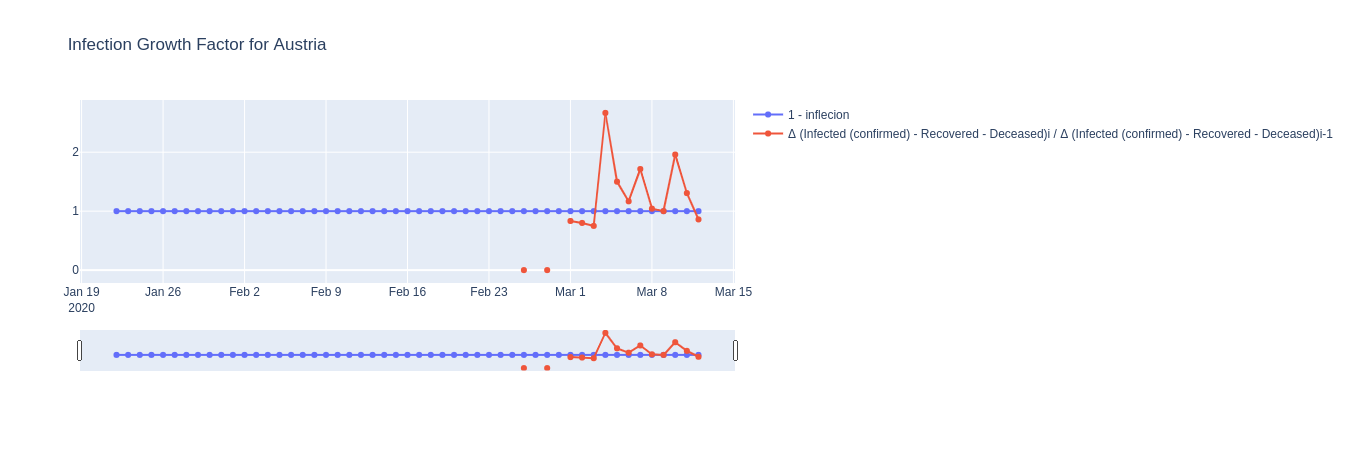

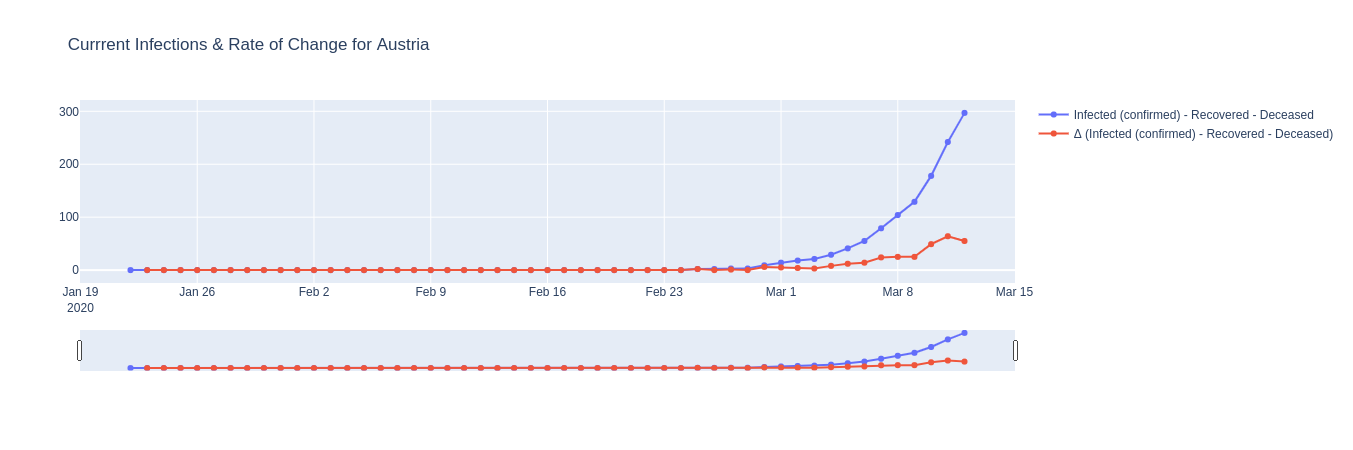

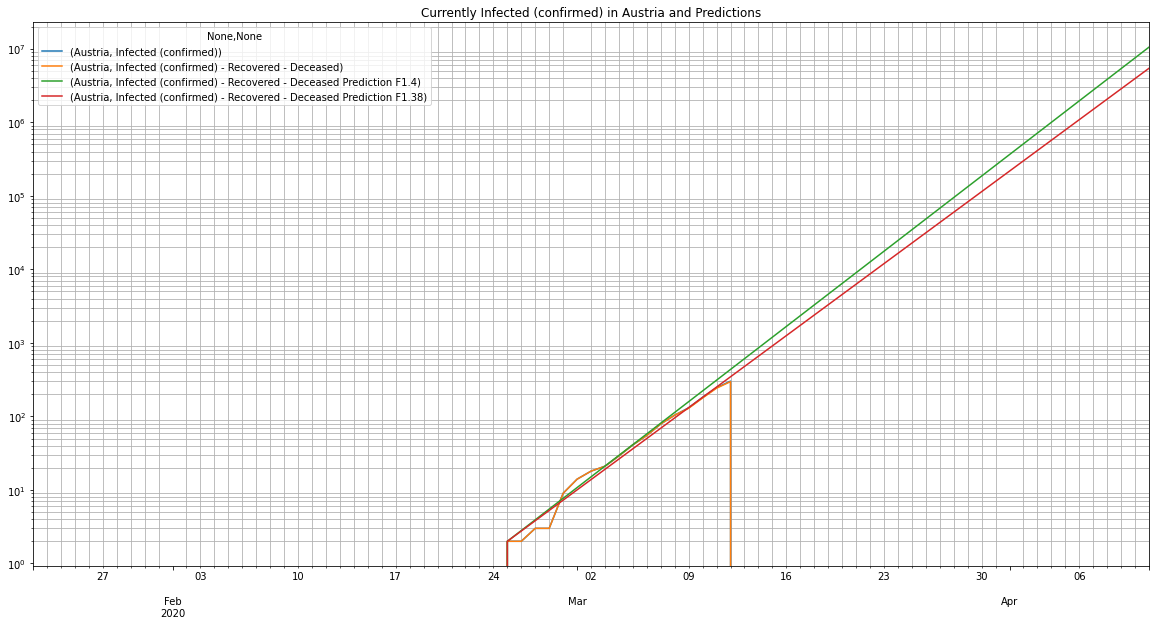

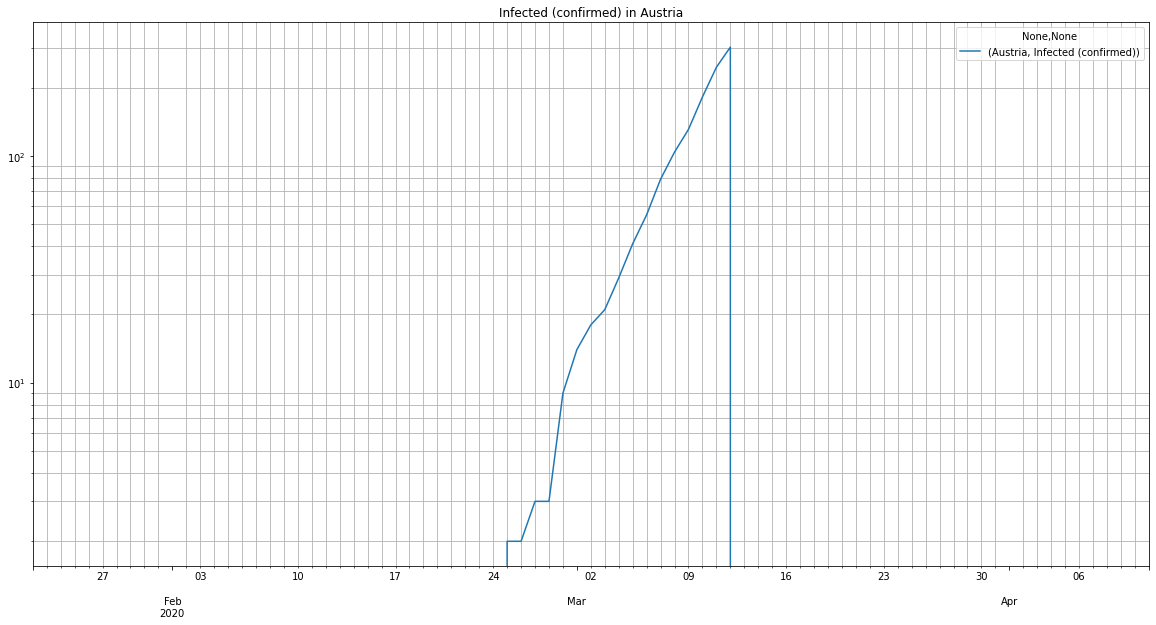

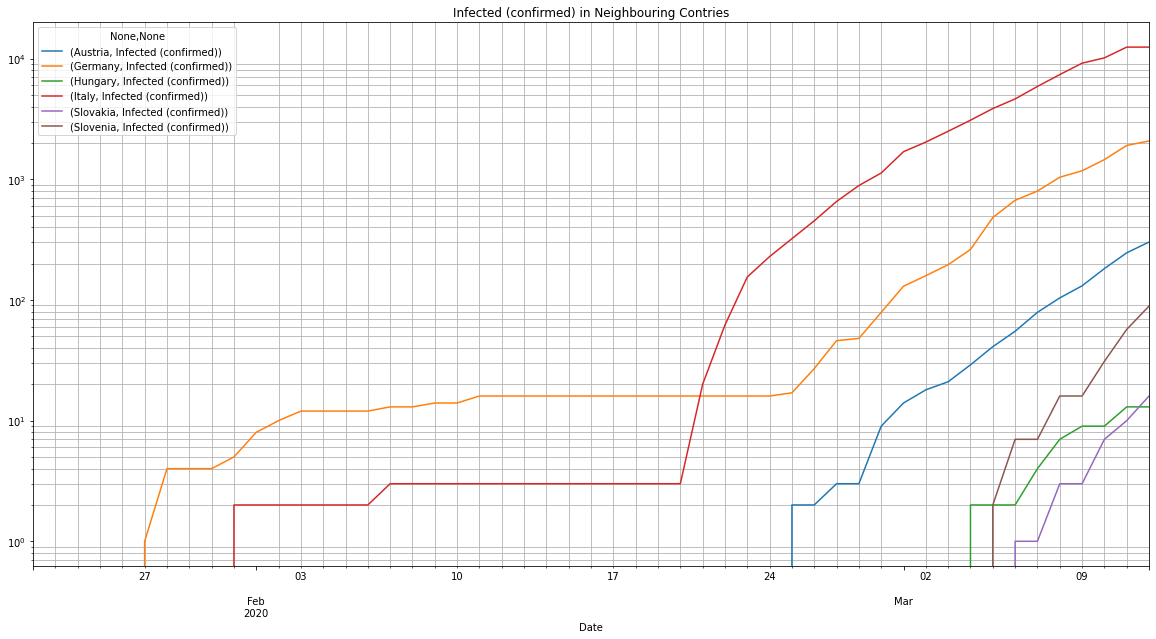

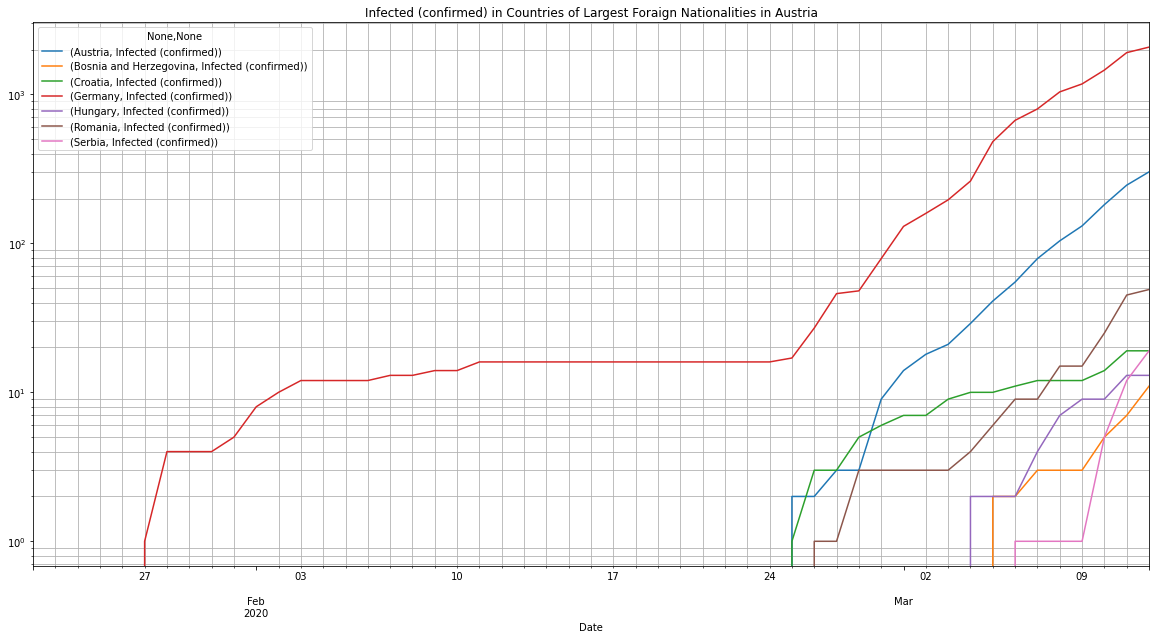

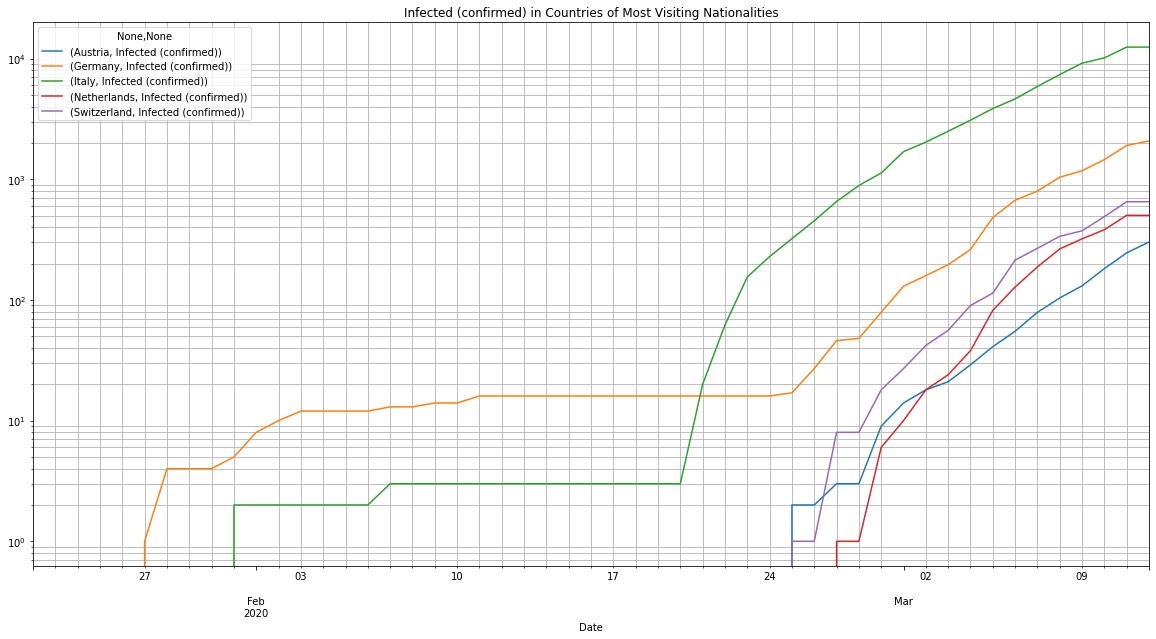

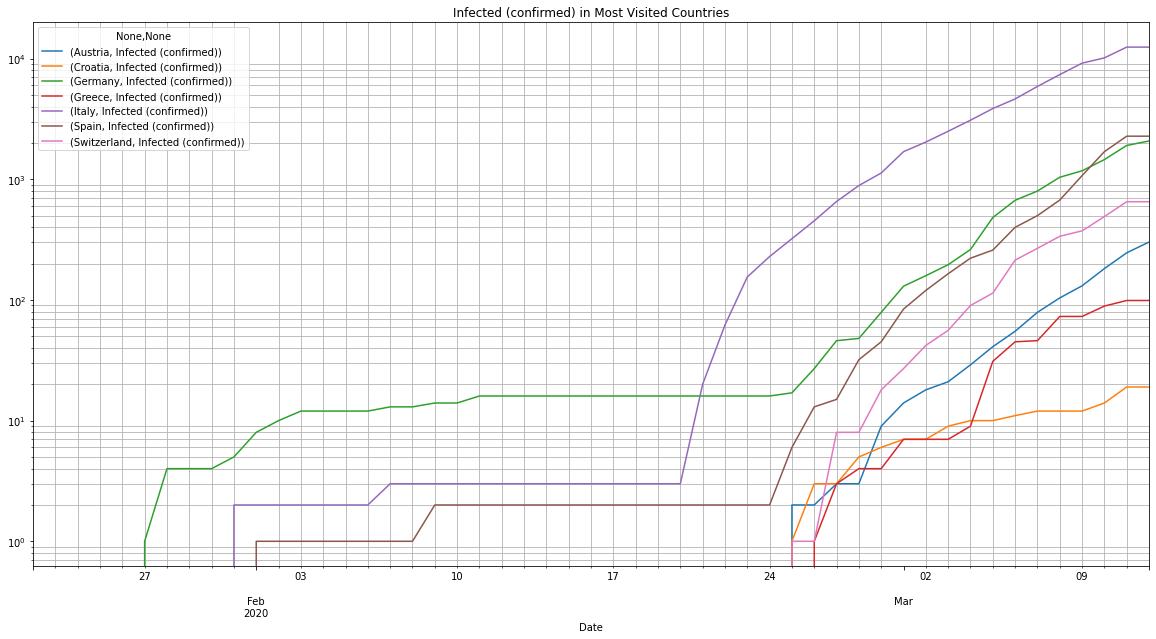

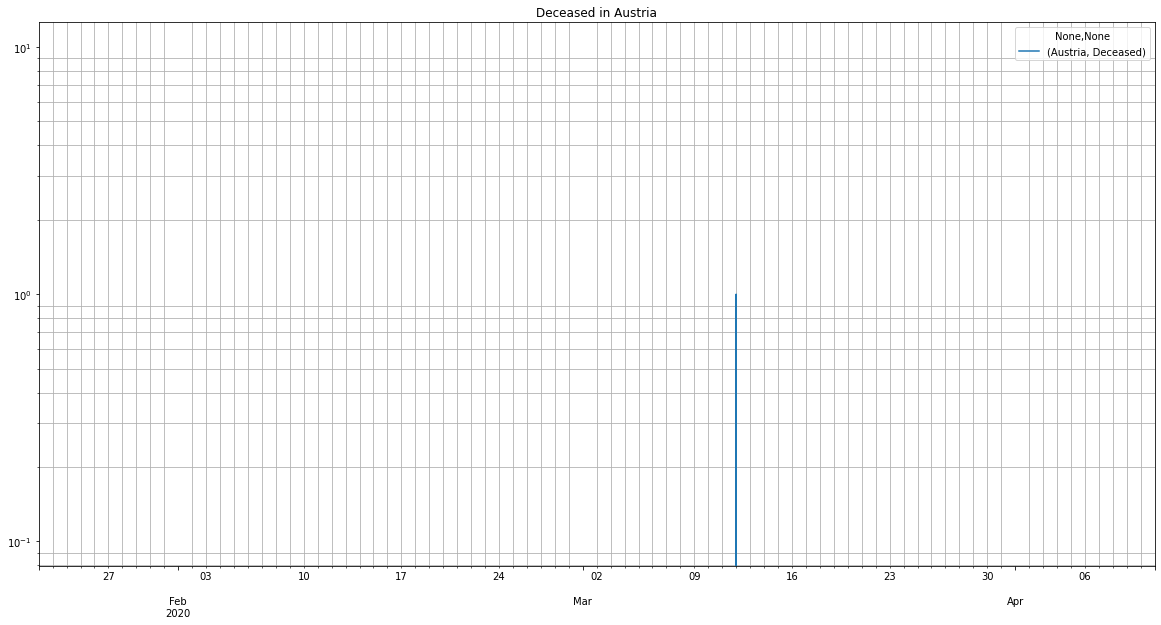

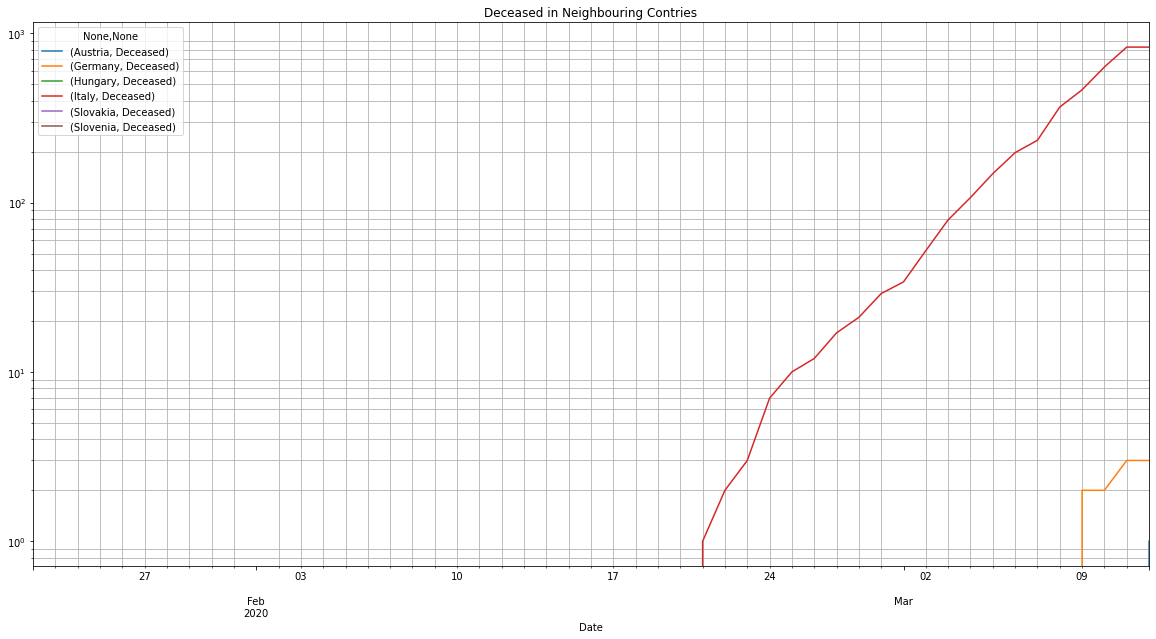

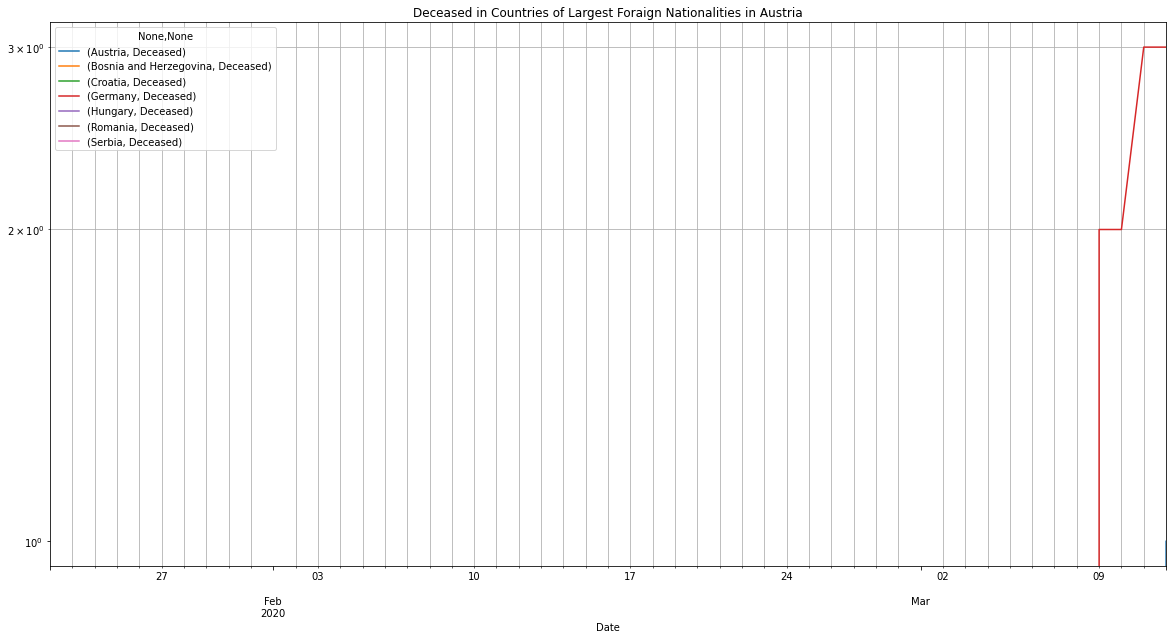

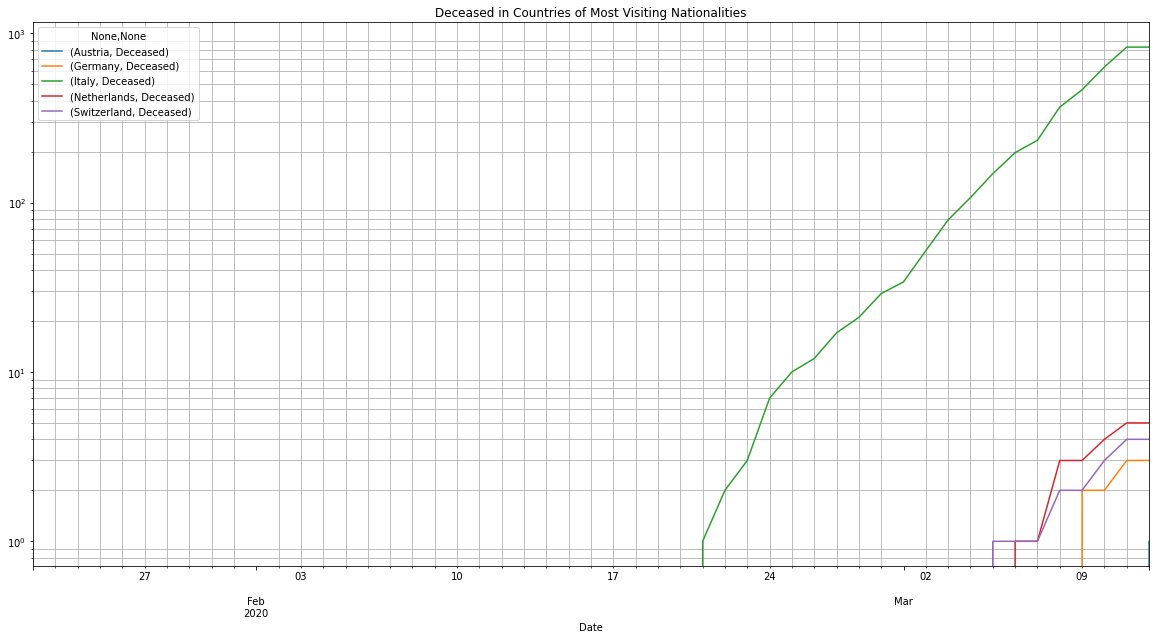

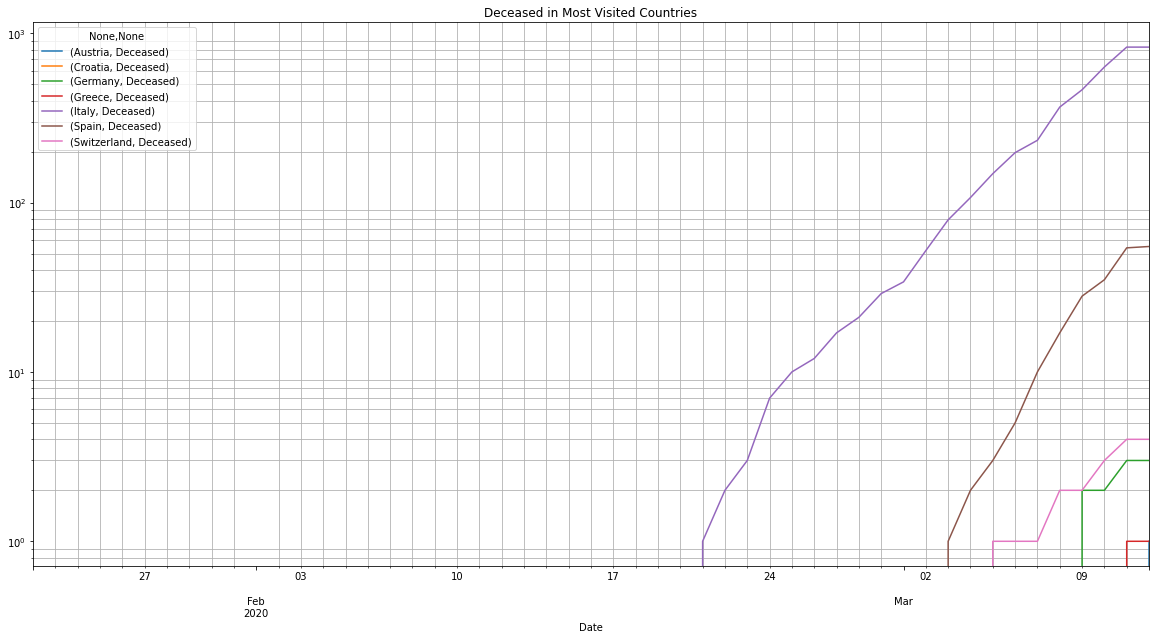

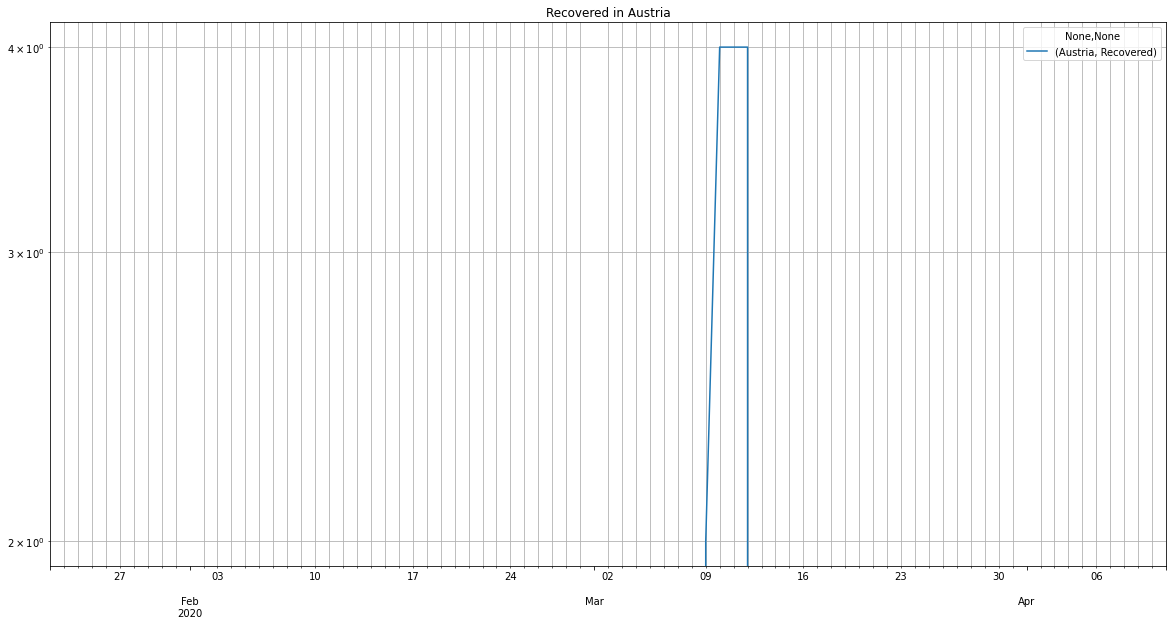

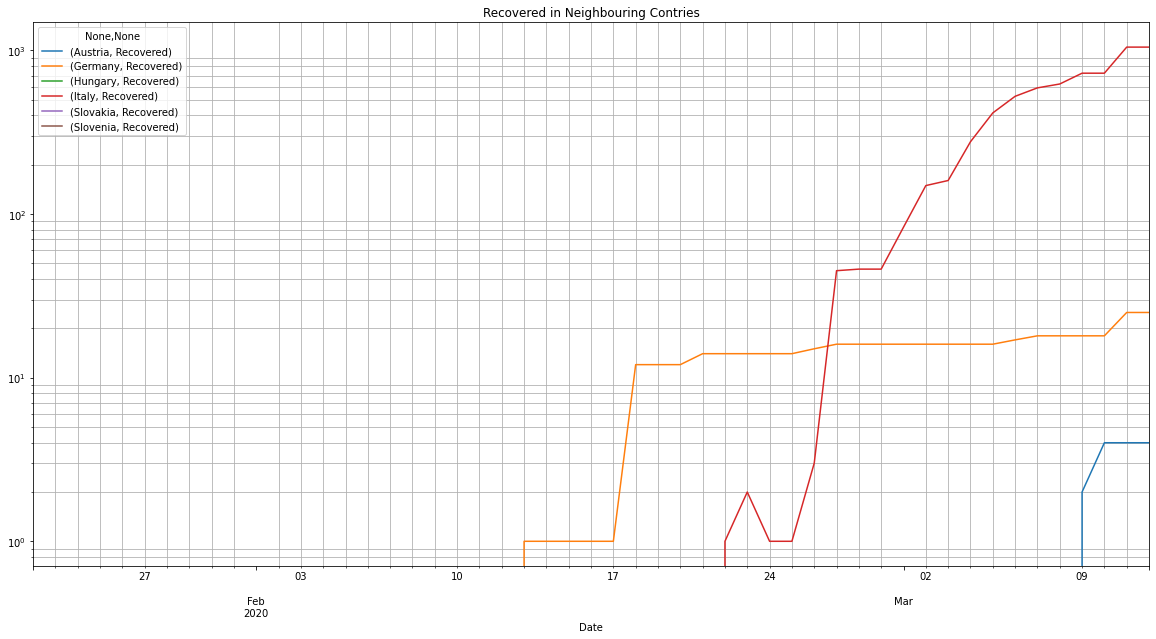

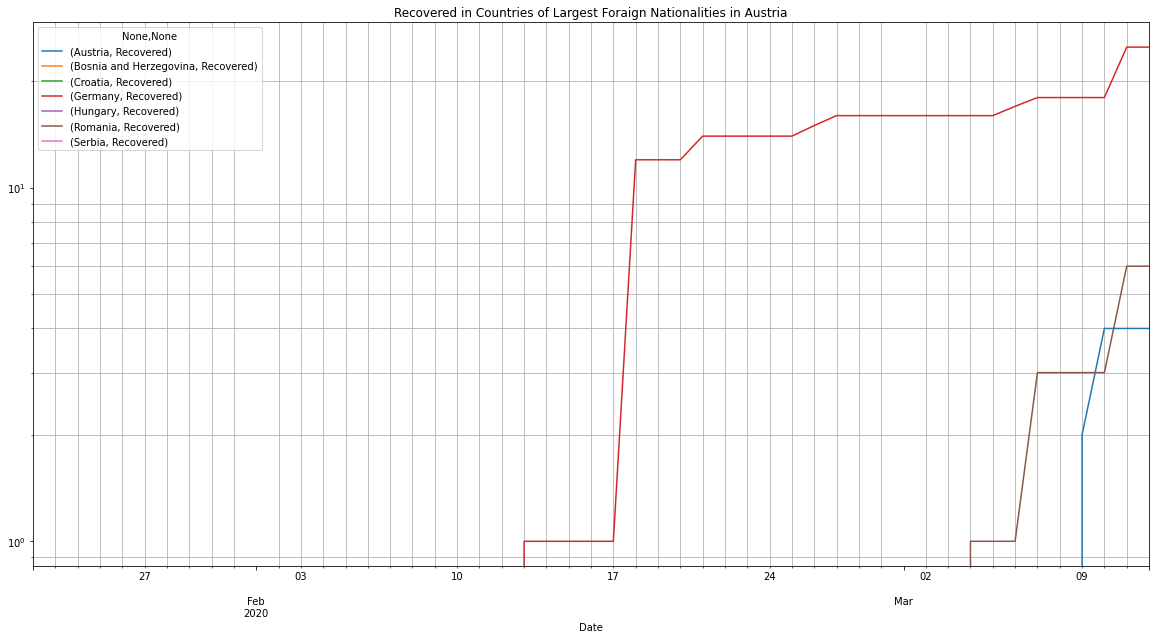

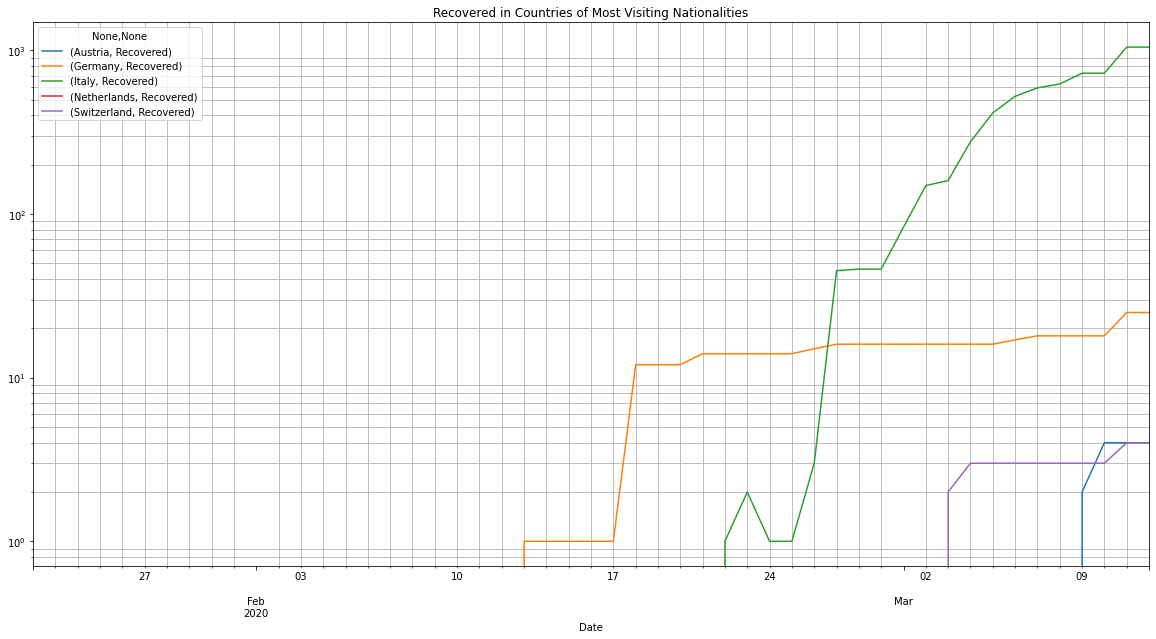

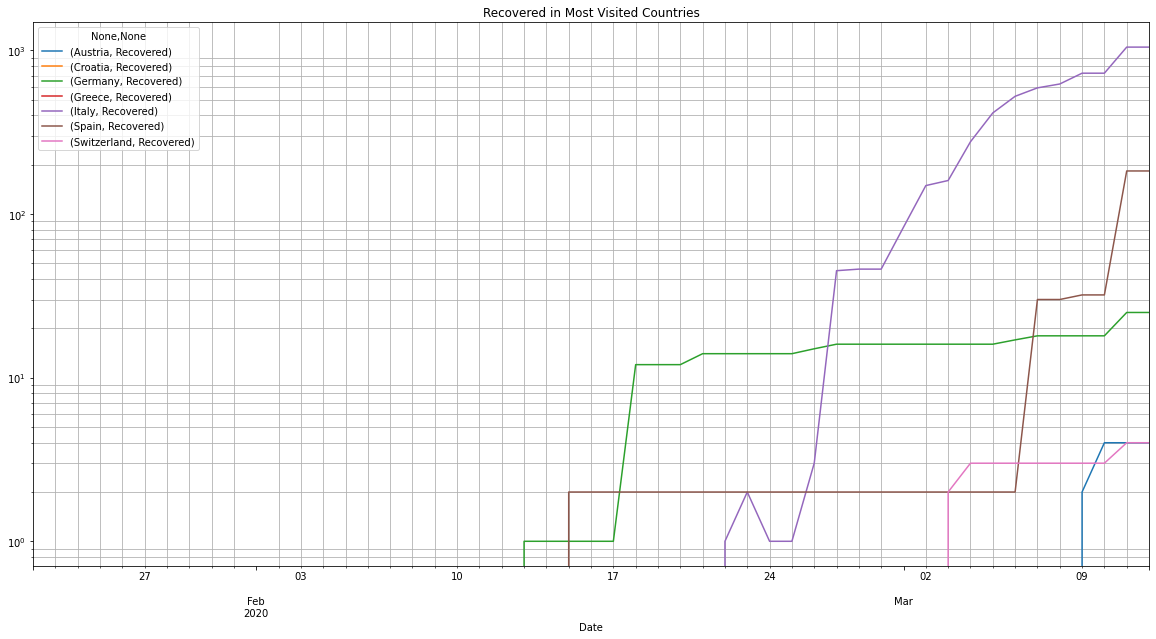

In [17]:
import lib.csse_covid_19_dataset.io as io
import os
import plotly.graph_objects as go

latest_data_date = df_prep.index[-1].strftime("%Y-%m-%d")
    
directory = "export/{}/".format(latest_data_date)
if not os.path.exists(directory):
    os.makedirs(directory)


# Growth factor
title = "Infection Growth Factor for {}".format(data.at)
df_at.loc[:, pandas.IndexSlice[data.at, '1 - inflecion']] = 1

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_at.index, 
                         y=df_at[(data.at, '1 - inflecion')], 
                         name='1 - inflecion',
                         mode='lines+markers'))
fig.add_trace(go.Scatter(x=df_temp.index, 
                         y=df_at[(data.at, infected_recovered_deceased_growth_factor_column_name)], 
                         name=infected_recovered_deceased_growth_factor_column_name,
                         mode='lines+markers'))
fig.update_layout(title_text=title, xaxis_rangeslider_visible=True)
fig.show()
fig.write_image(directory+title+".png")
io.saveDataCsv(df_at[[(data.at, '1 - inflecion'), (data.at, infected_recovered_deceased_growth_factor_column_name)]],
               directory, title)
#io.saveDataCsv(df_at.loc[:, pandas.IndexSlice[data.at, ['1 - inflecion', infected_recovered_deceased_growth_factor_column_name]]],
#               directory, title)


# Current infections and change rate
title = "Currrent Infections & Rate of Change for {}".format(data.at)
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_at.index, 
                         y=df_at[(data.at, infected_recovered_deceased_column_name)], 
                         name=infected_recovered_deceased_column_name,
                         mode='lines+markers'))
fig.add_trace(go.Scatter(x=df_temp.index, 
                         y=df_at[(data.at, infected_recovered_deceased_change_column_name)], 
                         name=infected_recovered_deceased_change_column_name,
                         mode='lines+markers'))
fig.update_layout(title_text=title, xaxis_rangeslider_visible=True)
fig.show()
fig.write_image(directory+title+".png")
io.saveDataCsv(df_at.loc[:, pandas.IndexSlice[data.at, [infected_recovered_deceased_column_name, infected_recovered_deceased_change_column_name]]],
               directory, title)


df_at_infected_pred_title = "Currently {} in {} and Predictions".format(infected_column_name, data.at)
#df_at_infected_pred = df_at_pred.loc[:, pandas.IndexSlice[:, [infected_column_name, infected_recovered_deceased_column_name, infected_recovered_deceased_prediction_column_name, infected_prediction_logistic_curve_column_name]]]
df_at_infected_pred = df_at_pred.loc[:, pandas.IndexSlice[:, [infected_column_name, infected_recovered_deceased_column_name, infected_recovered_deceased_prediction_1_4_column_name, infected_recovered_deceased_prediction_1_38_column_name]]]
io.saveDataCsv(df_at_infected_pred, directory, infected_column_name+"_"+df_at_infected_pred_title)
io.plotAndSavePngMatplotlib(df_at_infected_pred, df_at_infected_pred_title, (20, 10), True, directory, infected_column_name+"_"+df_at_infected_pred_title)

def displayAndSaveData(column, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing):
    df_at_title = "{} in {}".format(column, data.at)
    df_at_neighbours_title = "{} in Neighbouring Contries".format(column)
    df_at_nationalities_title = "{} in Countries of Largest Foraign Nationalities in {}".format(column, data.at)
    df_at_travel_incomming_title = "{} in Countries of Most Visiting Nationalities".format(column)
    df_at_travel_outgoing_title = "{} in Most Visited Countries".format(column)

    df_at = df_at_pred.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_neighbours = df_at_neighbours.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_nationalities = df_at_nationalities.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_travel_incomming = df_at_travel_incomming.loc[:, pandas.IndexSlice[:, [column]]]
    df_at_travel_outgoing = df_at_travel_outgoing.loc[:, pandas.IndexSlice[:, [column]]]

    io.saveDataCsv(df_at, directory, column+"_"+df_at_title)
    io.saveDataCsv(df_at_neighbours, directory, column+"_"+df_at_neighbours_title)
    io.saveDataCsv(df_at_nationalities, directory, column+"_"+df_at_nationalities_title)
    io.saveDataCsv(df_at_travel_incomming, directory, column+"_"+df_at_travel_incomming_title)
    io.saveDataCsv(df_at_travel_outgoing, directory, column+"_"+df_at_travel_outgoing_title)

    io.plotAndSavePngMatplotlib(df_at, df_at_title, (20, 10), True, directory, column+"_"+df_at_title)
    io.plotAndSavePngMatplotlib(df_at_neighbours, df_at_neighbours_title, (20, 10), True, directory, column+"_"+df_at_neighbours_title)
    io.plotAndSavePngMatplotlib(df_at_nationalities, df_at_nationalities_title, (20, 10), True, directory, column+"_"+df_at_nationalities_title)
    io.plotAndSavePngMatplotlib(df_at_travel_incomming, df_at_travel_incomming_title, (20, 10), True, directory, column+"_"+df_at_travel_incomming_title)
    io.plotAndSavePngMatplotlib(df_at_travel_outgoing, df_at_travel_outgoing_title, (20, 10), True, directory, column+"_"+df_at_travel_outgoing_title)
    
displayAndSaveData(infected_column_name, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing)
displayAndSaveData(deceased_column_name, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing)
displayAndSaveData(recovered_column_name, df_at, df_at_neighbours, df_at_nationalities, df_at_travel_incomming, df_at_travel_outgoing)
